## 용어
- 로짓(logit): (0~1이 아니라)±∞의 범위에서 어떤 클래스에 속할 확률을 결정하는 함수(유의어: 로그 오즈)
- 오즈(odds): '실패(0)'에 대한 '성공(1)'의 비율
- 로그 오즈(log odds): 변환 모델(선형)의 응답변수. 이 값을 통해 확률을 구한다.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## 로지스틱 회귀(Logistic Regression)
- 데이터 위주의 접근 방식이라기보다, 구조화된 모델의 접근 방식
- 빠른 계산 속도 및 새로운 데이터에 대한 빠른 점수 산정 덕분에 다양한 분야에서 널리 사용

### 로짓(logit)

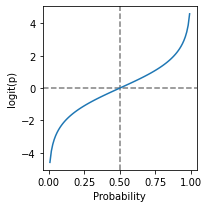

In [5]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()